# Распознавание текста

## CRNN+CTC loss baseline

В данном ноутбуке представлен baseline модели распознавания текста с помощью CRNN модели и CTC loss. Вы можете добавить новые аугментации или изменить структуру данной модели, или же попробовать совершенно новую архитектуру.

# 0. Установка и подгрузука библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
!nvidia-smi

Fri Mar  4 06:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    76W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [96]:
# !pip install numpy==1.20.3
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install opencv-python==4.5.2.52
# !pip install matplotlib==3.4.2

In [2]:
!pip install pytorch-lightning 

In [3]:
!pip install neptune-client

In [ ]:
!wget https://storage.yandexcloud.net/datasouls-competitions/ai-nto-final-2022/data.zip
!unzip -qq data.zip

--2022-03-04 05:39:31--  https://storage.yandexcloud.net/datasouls-competitions/ai-nto-final-2022/data.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6370765510 (5.9G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   5.93G  54.7MB/s    in 1m 58s  

2022-03-04 05:41:30 (51.5 MB/s) - ‘data.zip’ saved [6370765510/6370765510]



In [4]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import pytorch_lightning as pl
from random import shuffle


import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/nto_final/train_recognition.zip', '/content')
!unzip -qq train_recognition.zip

Mounted at /content/drive


In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
import pandas as pd

df = pd.read_csv('train_recognition/labels.csv')

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)


In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [ ]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)


In [ ]:
column_names = ['file_name', 'text']

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)
train_labels_cleaned = clean_labels(train_labels)

In [ ]:
ddd = []

for i in range(len(train_labels_cleaned)):
  ddd.append(("/content/" + train_img_paths[i], train_labels_cleaned[i]))

column_names = ['file_name', 'text']
df_to_save = pd.DataFrame(ddd, columns=column_names)

In [ ]:
df_to_save = pd.DataFrame(ddd, columns=column_names)

In [ ]:
rrr = pd.concat([df, df_to_save], axis=0)

In [ ]:
rrr

,file_name,text
0,0.png,"дверку,"
1,1.png,открыл
2,2.png,Я
3,3.png,хвостом.
4,4.png,вилял
...,...,...
86803,/content/data/words/h07/h07-071/h07-071-08-00.png,industries
86804,/content/data/words/f04/f04-028/f04-028-03-05.png,","
86805,/content/data/words/c04/c04-066/c04-066-04-06.png,charts
86806,/content/data/words/e07/e07-079/e07-079-01-02.png,.


In [ ]:
rrr.to_csv('new_labels.csv', index=False)

## 1. Разделим трейн датасет на обучающую и валидационную подвыборки


In [29]:
# with open('./train/labels.json') as f:
#     train_data = json.load(f)
train_data = pd.read_csv("train_recognition/labels.csv")
#train_data = train_data.drop(["base_image"], 1)

train_data = [(k, v) for k, v in train_data.values]
shuffle(train_data)
print('train len', len(train_data))

split_coef = 0.75
train_len = int(len(train_data)*split_coef)

train_data_splitted = train_data[:train_len]
val_data_splitted = train_data[train_len:]

print('train len after split', len(train_data_splitted))
print('val len after split', len(val_data_splitted))

# with open('./train/train_labels_splitted.json', 'w') as f:
#     json.dump(dict(train_data_splitted), f)
    
# with open('./train/val_labels_splitted.json', 'w') as f:
#     json.dump(dict(val_data_splitted), f)

train len 248508
train len after split 186381
val len after split 62127


## 2. Зададим параметры обучения

Здесь мы можем поправить конфиги обучения - задать размер батча, количество эпох, размер входных изображений, а также установить пути к датасетам.

In [30]:
labels = [v for k, v in train_data]
alphabet = ''.join(set(list("".join(labels))))

In [31]:
max_label = max([len(v) for v in labels])
max_label

23

In [32]:
a = list(alphabet)
a.sort()
alphabet = ''.join(a)

In [33]:
alphabet

' !"#%&\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'

In [278]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config_json = {
    "alphabet": alphabet,
    "save_dir": "/content/drive/MyDrive/nto_final/train/experiments_attent/test",
    "num_epochs": 45,
    "image": {
        "width": 256,
        "height": 50
    },
    "train": {
        "root_path": "",
        "json_path": dict(train_data_splitted),
        "batch_size": 16
    },
    "val": {
        "root_path": "",
        "json_path": dict(val_data_splitted),
        "batch_size": 16
    }
}

## 3. Теперь определим класс датасета (torch.utils.data.Dataset) и другие вспомогательные функции

In [72]:
from tqdm import tqdm_notebook
from skimage import transform, color, filters
from PIL import Image

In [252]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, json_path, root_path, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(json_path, root_path, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=False
    )
    return data_loader


class OCRDataset(Dataset):
    def __init__(self, json_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
#         with open(json_path, 'r') as f:
#             data = json.load(f) --- костыль
        data = json_path
        self.data_len = len(data)
        
        self.images = []
        self.texts = []
        for img_name, text in tqdm.tqdm(data.items()):
            self.texts.append(text)
            image = img_name
            self.images.append(image)
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        nnimg = Image.new("RGB", image.size)
        nnimg.paste(image)
        image = nnimg
        img = self.transform(image)
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        return img, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

(74, 72, 3)


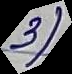

In [253]:
img = cv2.imread('/content/train_recognition/images/75226.png')
print(img.shape)
Image.open('/content/train_recognition/images/75226.png')

## 4. Здесь определен Токенайзер - вспопогательный класс, который преобразует текст в числа

Разметка-текст с картинок преобразуется в числовое представление, на которых модель может учиться. Также может преобразовывать числовое предсказание модели обратно в текст.

In [254]:
OOV_TOKEN = '<OOV>'
EOS_TOKEN = '<eos>'
SOS_TOKEN = '<sos>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 3 for (idx, value) in enumerate(alphabet)}
    char_map[SOS_TOKEN] = 0
    char_map[OOV_TOKEN] = 1
    char_map[EOS_TOKEN] = 2
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append([self.char_map[SOS_TOKEN]] +
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word] + [self.char_map[EOS_TOKEN]] + [self.char_map[OOV_TOKEN]] * (23 - len(word))
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[SOS_TOKEN]
                    and char_enc != self.char_map[EOS_TOKEN]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

## 5. Accuracy в качестве метрики

Accuracy измеряет долю предсказанных строк текста, которые полностью совпадают с таргет текстом.

In [255]:
# !sudo pip install fastwer
# import fastwer

In [256]:
# -*- coding: utf-8 -*-
def levenshtein_distance(first, second):
    distance = [[0 for _ in range(len(second) + 1)]
                for _ in range(len(first) + 1)]
    for i in range(len(first) + 1):
        for j in range(len(second) + 1):
            if i == 0:
                distance[i][j] = j
            elif j == 0:
                distance[i][j] = i
            else:
                diag = distance[i - 1][j - 1] + (first[i - 1] != second[j - 1])
                upper = distance[i - 1][j] + 1
                left = distance[i][j - 1] + 1
                distance[i][j] = min(diag, upper, left)
    return distance[len(first)][len(second)]


def cer(pred_texts, gt_texts):
    assert len(pred_texts) == len(gt_texts)
    lev_distances, num_gt_chars = 0, 0
    for pred_text, gt_text in zip(pred_texts, gt_texts):
        lev_distances += levenshtein_distance(pred_text, gt_text)
        num_gt_chars += len(gt_text)
    return lev_distances / (num_gt_chars + 1e-10)

In [257]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

## 6. Аугментации

Здесь мы задаем базовые аугментации для модели. Вы можете написать свои или использовать готовые библиотеки типа albumentations

In [258]:
tokenizer = Tokenizer(config_json['alphabet'])
# data = OCRDataset("/content/train/train_labels_splitted.json", "/content/train/images", tokenizer, get_train_transforms(config_json['image']['height'], config_json['image']['width']))

In [259]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image



def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((height, width)),
        # MoveChannels(to_channels_first=True),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        torchvision.transforms.RandomRotation(5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

    ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((height, width)),
        # MoveChannels(to_channels_first=True),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transforms

## 7. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [260]:
class TPS_SpatialTransformerNetwork(nn.Module):
    """ Rectification Network of RARE, namely TPS based STN """

    def __init__(self, F, I_size, I_r_size, I_channel_num=1):
        """ Based on RARE TPS
        input:
            batch_I: Batch Input Image [batch_size x I_channel_num x I_height x I_width]
            I_size : (height, width) of the input image I
            I_r_size : (height, width) of the rectified image I_r
            I_channel_num : the number of channels of the input image I
        output:
            batch_I_r: rectified image [batch_size x I_channel_num x I_r_height x I_r_width]
        """
        super(TPS_SpatialTransformerNetwork, self).__init__()
        self.F = F
        self.I_size = I_size
        self.I_r_size = I_r_size  # = (I_r_height, I_r_width)
        self.I_channel_num = I_channel_num
        self.LocalizationNetwork = LocalizationNetwork(self.F, self.I_channel_num)
        self.GridGenerator = GridGenerator(self.F, self.I_r_size)

    def forward(self, batch_I):
        batch_C_prime = self.LocalizationNetwork(batch_I)  # batch_size x K x 2
        build_P_prime = self.GridGenerator.build_P_prime(batch_C_prime)  # batch_size x n (= I_r_width x I_r_height) x 2
        build_P_prime_reshape = build_P_prime.reshape([build_P_prime.size(0), self.I_r_size[0], self.I_r_size[1], 2])
        batch_I_r = F.grid_sample(batch_I, build_P_prime_reshape, padding_mode='border')

        return batch_I_r


class LocalizationNetwork(nn.Module):
    """ Localization Network of RARE, which predicts C' (K x 2) from I (I_width x I_height) """

    def __init__(self, F, I_channel_num):
        super(LocalizationNetwork, self).__init__()
        self.F = F
        self.I_channel_num = I_channel_num
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.I_channel_num, out_channels=64, kernel_size=3, stride=1, padding=1,
                      bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 64 x I_height/2 x I_width/2
            nn.Conv2d(64, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 128 x I_height/4 x I_width/4
            nn.Conv2d(128, 256, 3, 1, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 256 x I_height/8 x I_width/8
            nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)  # batch_size x 512
        )

        self.localization_fc1 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(True))
        self.localization_fc2 = nn.Linear(256, self.F * 2)

        # Init fc2 in LocalizationNetwork
        self.localization_fc2.weight.data.fill_(0)
        """ see RARE paper Fig. 6 (a) """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = np.linspace(0.0, -1.0, num=int(F / 2))
        ctrl_pts_y_bottom = np.linspace(1.0, 0.0, num=int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        initial_bias = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        self.localization_fc2.bias.data = torch.from_numpy(initial_bias).float().view(-1)

    def forward(self, batch_I):
        """
        input:     batch_I : Batch Input Image [batch_size x I_channel_num x I_height x I_width]
        output:    batch_C_prime : Predicted coordinates of fiducial points for input batch [batch_size x F x 2]
        """
        batch_size = batch_I.size(0)
        features = self.conv(batch_I).view(batch_size, -1)
        batch_C_prime = self.localization_fc2(self.localization_fc1(features)).view(batch_size, self.F, 2)
        return batch_C_prime


class GridGenerator(nn.Module):
    """ Grid Generator of RARE, which produces P_prime by multipling T with P """

    def __init__(self, F, I_r_size):
        """ Generate P_hat and inv_delta_C for later """
        super(GridGenerator, self).__init__()
        self.eps = 1e-6
        self.I_r_height, self.I_r_width = I_r_size
        self.F = F
        self.C = self._build_C(self.F)  # F x 2
        self.P = self._build_P(self.I_r_width, self.I_r_height)
        self.register_buffer("inv_delta_C", torch.tensor(self._build_inv_delta_C(self.F, self.C)).float())  # F+3 x F+3
        self.register_buffer("P_hat", torch.tensor(self._build_P_hat(self.F, self.C, self.P)).float())  # n x F+3

    def _build_C(self, F):
        """ Return coordinates of fiducial points in I_r; C """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = -1 * np.ones(int(F / 2))
        ctrl_pts_y_bottom = np.ones(int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        C = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        return C  # F x 2

    def _build_inv_delta_C(self, F, C):
        """ Return inv_delta_C which is needed to calculate T """
        hat_C = np.zeros((F, F), dtype=float)  # F x F
        for i in range(0, F):
            for j in range(i, F):
                r = np.linalg.norm(C[i] - C[j])
                hat_C[i, j] = r
                hat_C[j, i] = r
        np.fill_diagonal(hat_C, 1)
        hat_C = (hat_C ** 2) * np.log(hat_C)
        # print(C.shape, hat_C.shape)
        delta_C = np.concatenate(  # F+3 x F+3
            [
                np.concatenate([np.ones((F, 1)), C, hat_C], axis=1),  # F x F+3
                np.concatenate([np.zeros((2, 3)), np.transpose(C)], axis=1),  # 2 x F+3
                np.concatenate([np.zeros((1, 3)), np.ones((1, F))], axis=1)  # 1 x F+3
            ],
            axis=0
        )
        inv_delta_C = np.linalg.inv(delta_C)
        return inv_delta_C  # F+3 x F+3

    def _build_P(self, I_r_width, I_r_height):
        I_r_grid_x = (np.arange(-I_r_width, I_r_width, 2) + 1.0) / I_r_width  # self.I_r_width
        I_r_grid_y = (np.arange(-I_r_height, I_r_height, 2) + 1.0) / I_r_height  # self.I_r_height
        P = np.stack(  # self.I_r_width x self.I_r_height x 2
            np.meshgrid(I_r_grid_x, I_r_grid_y),
            axis=2
        )
        return P.reshape([-1, 2])  # n (= self.I_r_width x self.I_r_height) x 2

    def _build_P_hat(self, F, C, P):
        n = P.shape[0]  # n (= self.I_r_width x self.I_r_height)
        P_tile = np.tile(np.expand_dims(P, axis=1), (1, F, 1))  # n x 2 -> n x 1 x 2 -> n x F x 2
        C_tile = np.expand_dims(C, axis=0)  # 1 x F x 2
        P_diff = P_tile - C_tile  # n x F x 2
        rbf_norm = np.linalg.norm(P_diff, ord=2, axis=2, keepdims=False)  # n x F
        rbf = np.multiply(np.square(rbf_norm), np.log(rbf_norm + self.eps))  # n x F
        P_hat = np.concatenate([np.ones((n, 1)), P, rbf], axis=1)
        return P_hat  # n x F+3

    def build_P_prime(self, batch_C_prime):
        """ Generate Grid from batch_C_prime [batch_size x F x 2] """
        batch_size = batch_C_prime.size(0)
        batch_inv_delta_C = self.inv_delta_C.repeat(batch_size, 1, 1)
        batch_P_hat = self.P_hat.repeat(batch_size, 1, 1)
        batch_C_prime_with_zeros = torch.cat((batch_C_prime, torch.zeros(
            batch_size, 3, 2).float().cuda()), dim=1)  # batch_size x F+3 x 2
        batch_T = torch.bmm(batch_inv_delta_C, batch_C_prime_with_zeros)  # batch_size x F+3 x 2
        batch_P_prime = torch.bmm(batch_P_hat, batch_T)  # batch_size x n x 2
        return batch_P_prime  # batch_size x n x 2

In [261]:
# SOURCE: https://github.com/clovaai/deep-text-recognition-benchmark/blob/c2e28f5c0d30a81e884d358d0874c7a712e7515b/modules/prediction.py # noqa
# + Some easy refactoring
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Attention(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(Attention, self).__init__()
        self.attention_cell = AttentionCell(input_size, hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.generator = nn.Linear(hidden_size, num_classes)

    def _char_to_onehot(self, input_char, onehot_dim=40):
        input_char = input_char.unsqueeze(1)
        batch_size = input_char.size(0)
        one_hot = torch.FloatTensor(batch_size, onehot_dim).zero_().to(device)
        one_hot = one_hot.scatter_(1, input_char, 1)
        return one_hot

    def forward(self, batch_H, text, is_train=True, batch_max_length=25):
        """
        input:
            batch_H : contextual_feature H = hidden state of encoder. [batch_size x num_steps x contextual_feature_channels]
            text : the text-index of each image. [batch_size x (max_length+1)]. +1 for [GO] token. text[:, 0] = [GO].
        output: probability distribution at each step [batch_size x num_steps x num_classes]
        """
        batch_size = batch_H.size(0)
        num_steps = batch_max_length  # +1 for [s] at end of sentence.

        output_hiddens = torch.FloatTensor(batch_size, num_steps, self.hidden_size).fill_(0).to(device)
        hidden = (torch.FloatTensor(batch_size, self.hidden_size).fill_(0).to(device),
                  torch.FloatTensor(batch_size, self.hidden_size).fill_(0).to(device))

        if is_train:
            for i in range(num_steps):
                # one-hot vectors for a i-th char. in a batch
                # print(num_steps)
                # print(text.shape)
                char_onehots = self._char_to_onehot(text[:, i], onehot_dim=self.num_classes)
                # hidden : decoder's hidden s_{t-1}, batch_H : encoder's hidden H, char_onehots : one-hot(y_{t-1})
                hidden, alpha = self.attention_cell(hidden, batch_H, char_onehots)
                output_hiddens[:, i, :] = hidden[0]  # LSTM hidden index (0: hidden, 1: Cell)
            probs = self.generator(output_hiddens)

        else:
            targets = torch.LongTensor(batch_size).fill_(0).to(device)  # [GO] token
            probs = torch.FloatTensor(batch_size, num_steps, self.num_classes).fill_(0).to(device)

            for i in range(num_steps):
                char_onehots = self._char_to_onehot(targets, onehot_dim=self.num_classes)
                hidden, alpha = self.attention_cell(hidden, batch_H, char_onehots)
                probs_step = self.generator(hidden[0])
                probs[:, i, :] = probs_step
                _, next_input = probs_step.max(1)
                targets = next_input

        return probs  # batch_size x num_steps x num_classes


class AttentionCell(nn.Module):

    def __init__(self, input_size, hidden_size, num_embeddings):
        super(AttentionCell, self).__init__()
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)  # either i2i or h2h should have bias
        self.score = nn.Linear(hidden_size, 1, bias=False)
        self.rnn = nn.LSTMCell(input_size + num_embeddings, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, prev_hidden, batch_H, char_onehots):
        # [batch_size x num_encoder_/content/experiments_lstm_1/test/model-63-0.1780.ckptstep x num_channel] -> [batch_size x num_encoder_step x hidden_size]
        batch_H_proj = self.i2h(batch_H)
        prev_hidden_proj = self.h2h(prev_hidden[0]).unsqueeze(1)
        e = self.score(torch.tanh(batch_H_proj + prev_hidden_proj))  # batch_size x num_encoder_step * 1

        alpha = F.softmax(e, dim=1)
        context = torch.bmm(alpha.permute(0, 2, 1), batch_H).squeeze(1)  # batch_size x num_channel
        concat_context = torch.cat([context, char_onehots], 1)  # batch_size x (num_channel + num_embedding)
        cur_hidden = self.rnn(concat_context, prev_hidden)
        return cur_hidden, alpha

In [262]:
# !git clone --recursive https://github.com/parlance/ctcdecode.git
# !cd ctcdecode && pip install .

## 8. Переходим к самому скрипту обучения - циклы трейна и валидации

In [263]:
!pip install catboost

In [264]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 25):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x).permute(1, 0, 2)

In [265]:
    def test_beam_search_decoder_batch():
        probs_seq = torch.FloatTensor([self.probs_seq1, self.probs_seq2])
        decoder = ctcdecode.CTCBeamDecoder(
            self.vocab_list, beam_width=2, blank_id=self.vocab_list.index("_"), num_processes=24
        )
        beam_results, beam_scores, timesteps, out_seq_len = decoder.decode(probs_seq)
        output_str1 = tokenizer.decode(beam_results[0][0], self.vocab_list, out_seq_len[0][0])
        output_str2 = tokenizer.decode(beam_results[1][0], self.vocab_list, out_seq_len[1][0])
        del decoder

In [266]:
# CTC Pytorch Models
import torch
from torch import nn, optim
from torchvision.models.resnet import BasicBlock
import numpy as np
from torch.utils.model_zoo import load_url

rresnet_url = 'https://download.pytorch.org/models/resnet34-333f7ec4.pth'

def downsample(chan_in, chan_out, stride, pad=0):
    
    return nn.Sequential(
            nn.Conv2d(chan_in, chan_out, kernel_size=1, stride=stride, bias=False,
                      padding=pad),
            nn.BatchNorm2d(chan_out)
            )

# create a residual network, modify the downsampling as input is rectangular
class CNN(nn.Module):
    """ FeatureExtractor of CRNN (https://arxiv.org/pdf/1507.05717.pdf) """

    def __init__(self, input_channel, output_channel=512):
        super(CNN, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]  # [64, 128, 256, 512]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 64x16x50
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 128x8x25
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),  # 256x8x25
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 256x4x25
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),  # 512x4x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 512x2x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True))  # 512x1x24

    def forward(self, input):
        return self.ConvNet(input)
    
    
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output
        
# SOURCE: https://github.com/clovaai/deep-text-recognition-benchmark/blob/c2e28f5c0d30a81e884d358d0874c7a712e7515b/model.py # noqa
"""
Copyright (c) 2019-present NAVER Corp.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import torch.nn as nn

criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)

class Model(nn.Module):

    def __init__(self, input_channel, output_channel, hidden_size, num_class, batch_max_length=24, img_size=(100, 300)):
        super(Model, self).__init__()
        self.batch_max_length = batch_max_length
#         # """ Transformation """
#         self.Transformation = TPS_SpatialTransformerNetwork(
#                 F=20, I_size=img_size, I_r_size=img_size, I_channel_num=input_channel)
        # else:
        #     print('No Transformation module specified')

        # """ FeatureExtraction """
        self.FeatureExtraction = CNN(input_channel, output_channel)
        self.FeatureExtraction_output = output_channel  # int(imgH/16-1) * 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))  # Transform final (imgH/16-1) -> 1


        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(
            RNN(self.FeatureExtraction_output, hidden_size, hidden_size, num_layers=1),
            RNN(hidden_size, hidden_size, hidden_size, num_layers=1)
        )
        self.SequenceModeling_output = hidden_size

        """ Prediction """
        # if opt.Prediction == 'CTC':
        #     self.Prediction = nn.Linear(self.SequenceModeling_output, opt.num_class)
        # elif opt.Prediction == 'Attn':
        self.pos_x = PositionalEncoding(self.SequenceModeling_output, max_len=100)
        self.Prediction = Attention(self.SequenceModeling_output, hidden_size, num_class)
#         self.emb = nn.Embedding(num_class, 256)
        self.pos_y = PositionalEncoding(self.SequenceModeling_output, max_len=25)


    def forward(self, input, text, is_train=True):
        # """ Transformation stage """
        # if not self.stages['Trans'] == "None":
#         input = self.Transformation(input)

        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        # if self.stages['Seq'] == 'BiLSTM':
        contextual_feature = self.SequenceModeling(visual_feature)
        # else:
        #     contextual_feature = visual_feature  # for convenience. this is NOT contextually modeled by BiLSTM

        """ Prediction stage """
        # if self.stages['Pred'] == 'CTC':
        #     prediction = self.Prediction(contextual_feature.contiguous())
        # else:
        
#         position = self.pos_x(contextual_feature.contiguous())
#         if is_train:
#             text = self.emb(text)
#             text = self.pos_y(text)
#         else:
#             target = text
        prediction = self.Prediction(contextual_feature, text, is_train, batch_max_length=self.batch_max_length)  # noqa
        return prediction
        
    def best_path_decode(self, xb, y=None, mode='eval'):
        
        with torch.no_grad():
            if mode == 'eval':
                out = self.forward(xb, None, is_train=False)
            else:
                out = self.forward(xb, y, is_train=True)
            softmax_out = out.argmax(2).data.cpu().numpy()
            char_list = []
            for i in range(0, softmax_out.shape[0]):
                dup_rm = softmax_out[i, :][np.insert(np.diff(softmax_out[i, :]).astype(np.bool), 0, True)]
                dup_rm = dup_rm[dup_rm != 0]
                char_list.append(dup_rm.astype(int))
                
        return char_list

    def training_step(self, train_batch, batch_idx):
        images, texts, enc_pad_texts, text_lens = train_batch
        images = images.to(DEVICE)
        enc_pad_texts = torch.tensor(enc_pad_texts)
        enc_pad_texts = enc_pad_texts.to(DEVICE)
        x_hat = model(images, enc_pad_texts[:, :-1])
        loss = criterion(x_hat.transpose(2, 1), enc_pad_texts[:, 1:])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, texts, enc_text, _ = val_batch
        images = images.to(DEVICE)
        enc_text = torch.tensor(enc_text)
        enc_text = enc_text.to(DEVICE)
        x_hat = model(images, None, is_train=False)
        loss = criterion(x_hat.transpose(2, 1), enc_text[:, 1:])
        self.log('val_loss', loss)


In [267]:
# !pip install ruclip==0.0.1

In [268]:
# import ruclip
# f"All models: {list(ruclip.MODELS.keys())}"

In [269]:
import neptune.new as neptune
run = neptune.init(
    project="Voidname/baselinento",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0NTExN2M3ZC0yNTU1LTQ2NzEtYWRlZC1hY2ZmMDhmOTllMWIifQ==",
)  # your credentials

https://app.neptune.ai/Voidname/baselinento/e/BAS-270
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [270]:
parameters = {
    'num_images': 'all',
    'learning_rate': 0.001,
    "batch_size_train": 64,
    "batch_size_val": 64,
    'n_epochs': 100,
    'img_hight': 100,
    'img_weight': 300,
    'attention': False,
    'backbone': 'resnet18',
    'aug': [
            "A.Resize(height, width)",
        "A.ChannelShuffle()",
        "A.GridDistortion()",
        "A.InvertImg(p=0.5)",
        "A.HorizontalFlip(p=0.4)",
        "A.ToGray(p=0.4)",
        "A.RandomBrightnessContrast(p=0.5)",
    ],
    "choice": "best_path_decode"

}
parameters = {
    'model' : "Attention CRNN"
}

run['model/parameters'] = parameters

In [271]:
from tqdm import tqdm_notebook

In [281]:
from functools import partialmethod
import tqdm

def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    cer_avg = AverageMeter()
    for images, texts, enc_text, _ in tqdm.tqdm(data_loader):
        batch_size = len(texts)
        text_preds, pred = predict(images, model, tokenizer, device, choice='greedy_serch')
        # cer_avg.update(fastwer.score(text_preds, texts, char_level=True), batch_size)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
        cer_avg.update(cer(texts,text_preds))
    # print(text_preds, texts, sep=' text pred \n')
    # print(pred)
    run['evaluation/epoch/cer'].log(cer_avg.avg)
    run['evaluation/epoch/cer'].log(cer_avg.avg)
    print(text_preds)
    print(texts)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    print(f'Validation, cer: {cer_avg.avg:.4f}')
    return cer_avg.avg


def train_loop(data_loader, model, criterion, optimizer, epoch, device='cuda'):
    loss_avg = AverageMeter()
    acc_avg = AverageMeter()
    cer_avg = AverageMeter()
    for images, texts, enc_pad_texts, text_lens in tqdm.tqdm(data_loader):
        model.train()
        model.zero_grad()
        images = images.to(DEVICE)
        # print(len(enc_pad_texts))
        # print(enc_pad_texts[0].shape, enc_pad_texts[1].shape)
        enc_pad_texts = torch.tensor(enc_pad_texts)
        enc_pad_texts = enc_pad_texts.to(DEVICE)
        batch_size = len(texts)
        output = model(images, enc_pad_texts[:, :-1])
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        loss = criterion(output.transpose(2, 1), enc_pad_texts[:, 1:])
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        text_preds = predict(images, model, tokenizer, device, enc_pad_texts[:, :-1], mode='train', choice='greedy_serch')
        # print(text_preds, texts)
        cer_avg.update(cer(texts, text_preds[0]), batch_size)
        acc_avg.update(get_accuracy(texts, text_preds[0]), batch_size)
  
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    run['train/epoch/loss'].log(loss_avg.avg)
    run['model/parameters/learning_rate'] = lr
    run['train/epoch/accuracy'].log(acc_avg.avg)
    run['train/epoch/cer'].log(cer_avg.avg)
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    print(f'Train, cer:{cer_avg.avg}')
    return loss_avg.avg, output.argmax(2).data, texts, lr


def predict(images, model, tokenizer, device, y=None, mode='eval', choice='greedy_serch'):
    images = images.to(device)
    if choice == 'best_path':
        if mode == 'eval':
            model.eval()
            pred = np.array(model.best_path_decode(images))
        else:
            pred = np.array(model.best_path_decode(images, y, mode='train'))
    elif choice == 'greedy_serch':
        if mode == 'eval':
            pred = model(images, None, is_train=False)
            pred = pred.argmax(2).data.detach().cpu().numpy()
        else:
            pred = model(images, y, is_train=True)
            pred = pred.argmax(2).data.detach().cpu().numpy()
#     chars = list(tokenizer.char_map.keys())
#     _ = chars.pop(chars.index("<BLANK>"))
#     with torch.no_grad():
#         output = model(images).permute(1, 0, 2).cpu().detach().numpy()
#     char_list = []
#     for i in range(0, output.shape[0]):
#         dup_rm = beam_search(output[i], chars)
# #         print(dup_rm)
#         char_list.append(dup_rm)
    text_preds = tokenizer.decode(pred)
    return text_preds, pred


def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        json_path=config['train']['json_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader(
        transforms=val_transforms,
        json_path=config['val']['json_path'],
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False
    )
    return train_loader, val_loader


def train(config):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    # train_loader, val_loader = get_loaders(tokenizer, config)

    model = Model(3, 512, 512, tokenizer.get_num_chars())
    #saves = torch.load("./train/experiments_attent/test/model-22-0.4357.ckpt")
    #model.load_state_dict(saves['model'])
    model.to(DEVICE)
    # model.load_pretrained_rnn()
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.003,
                                  weight_decay=0.01)
    #optimizer.load_state_dict(saves['lr'])
    best_cer = np.inf
    train_loader, val_loader = get_loaders(tokenizer, config_json)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        epochs=config['num_epochs'],
        steps_per_epoch=len(train_loader),
        max_lr=0.01,
    )
    #scheduler.load_state_dict(saves['sched'])
    #acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    for epoch in range(config['num_epochs']):
        loss_avg, pred, texts, lr = train_loop(train_loader, model, criterion, optimizer, epoch)
        print(tokenizer.decode(pred.detach().cpu().numpy()))
        print(texts)
        cer_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(cer_avg)
        if cer_avg < best_cer or epoch % 10 == 0:
            best_cer = cer_avg
            model_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{cer_avg:.4f}.ckpt')
            torch.save({'model' : model.state_dict(),
                       'epoch ': epoch,
                        'lr': optimizer.state_dict(),
                        'sched': scheduler.state_dict()
                       }, model_save_path)
            print('Model weights saved')

In [282]:
a = Model(3, 512, 512, tokenizer.get_num_chars())
s = 0
for el in a.parameters():
  s += len(el)
s

50361

In [ ]:
train(config_json)

100%|██████████| 186381/186381 [00:00<00:00, 1036056.17it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 11649/11649 [2:11:26<00:00,  1.48it/s]



Epoch 0, Loss: 0.57932, LR: 0.0004000
Train, cer:12308550765.316368
['Донтрольный', 'shome', 'нерег.', 'поивалт', '.', 'отожаль', 'уамотнени,', 'of', 'titires', ',', 'gost', 'te', 'волоц.']
('Контрольный', 'stones', 'нареч.', 'плавании', '.', 'слишиш', 'закончена;', 'of', "Marshams'", ',', 'great', 'be', 'полка.')


100%|██████████| 3883/3883 [07:08<00:00,  9.07it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


['порежне', 'demplomation', 'почель', 'the', 'the', 'anderted', 'потому', 'полод.', 'работа.', 'двугой', 'полом,', 'п', 'всего', 'sthines', '.']
('перенесли', 'manufactured', 'полка.', 'the', 'this', 'animals', 'непогода', 'имеют', 'решить', 'радил-', 'малей-', '4.', 'Она', 'resistance', '.')
Validation, acc: 0.1518
Validation, cer: 0.8385
Model weights saved


 21%|██        | 2438/11649 [27:24<1:43:01,  1.49it/s]

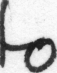

In [225]:
Image.open('/content/data/words/g01/g01-070/g01-070-02-00.png')

In [228]:
iimg = Image.open('/content/data/words/g01/g01-070/g01-070-02-00.png')
print(np.array(iimg).shape)

nnimg = Image.new("RGB", iimg.size)
print(np.array(nnimg).shape)
nnimg.save('aaaaa1.jpg')
nnimg.paste(iimg)
print(np.array(nnimg).shape)
nnimg.save('aaaaa2.jpg')
"""
nnimg.save('aaaaa.jpg')
rgbimg.paste(img)
rgbimg.save('foo.jpg')
"""

(73, 57)
(73, 57, 3)
(73, 57, 3)


"\nnnimg.save('aaaaa.jpg')\nrgbimg.paste(img)\nrgbimg.save('foo.jpg')\n"

In [ ]:
 import os
os.listdir("./")

In [ ]:
# model_dict = a.state_dict()
# pretrained_dict = torch.load('../input/other-add/model-20-0.6432.ckpt')
# pretrained_dict = {'rnn.{}'.format(".".join(k.split('.')[1:])): v for k, v in pretrained_dict.items() if 'rnn.{}'.format(".".join(k.split('.')[1:])) in model_dict}

## 9. Запускаем обучение!

In [ ]:
import os 
os.chdir(r'/kaggle/working')

In [ ]:
paths = os.listdir("./train/experiments_attent/test")

In [ ]:
paths

In [ ]:
def get_max_score(paths):
    epochs = [int(path.split('-')[1]) for path in paths]
    max_ep_ind = epochs.index(max(epochs))
    return paths[max_ep_ind]

In [ ]:
from IPython.display import FileLink
path = get_max_score(paths)
print(path)
FileLink(f"./train/experiments_attent/test/{path}")

## 10. Создание предсказаний для public-датасета

Сначала определим класс для создания предсказаний

In [ ]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = Model(3, 512, 512, tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path)['model'])
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        else:
            images = [images]
            one_image = True
#         else:
#             raise Exception(f"Input must contain np.ndarray, "
#                             f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

Инициализируем OCR predictor

In [ ]:
predictor = OcrPredictor(
    model_path=f'../input/other-add/attention-42-0.0866.ckpt',
    config=config_json
)

Посмотрим несколько предсказаний и создадим финальный json

In [ ]:
val_data_splitted[1]

In [ ]:
pred_json = {}
right_answers = []

count = 0
print_images = True
for img_name, target in val_data_splitted:
    img = Image.open(f'./train/images/{img_name}')

    pred = predictor(img)
    pred_json[img_name] = pred
    if pred[0] == target:
        right_answers.append(img_name)

    if print_images:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('Prediction: ', predictor(img))
        print("Target: ", target)
        count += 1

    if count > 30:
        print_images = False

In [ ]:
class AugCNN(nn.Module):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        path = os.path.join('./train/images', self.images[idx])
        image = Image.open(path)
        if self.transform:
            return self.transform(image)
        return image

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(right_answers, test_size=0.2)

In [ ]:
def get_val_transforms(height=None, width=None):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((height, width)),
        # MoveChannels(to_channels_first=True),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transforms

In [ ]:
transform = get_val_transforms(100, 300)

In [ ]:
train_dataset = AugCNN(x_train, transform)
test_dataset = AugCNN(x_test, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [ ]:
Auger_CNN = nn.Sequential(
    nn.Conv2d(3, 3, 1),
    nn.Conv2d(3, 16, 1),
    nn.Conv2d(16, 32, 1),
    nn.Conv2d(32, 16, 1),
    nn.Conv2d(16, 3, 1)
)

In [ ]:
def train_loop(data_loader, model, criterion, optimizer, epoch, device='cuda'):
    loss_avg = AverageMeter()
    for images in tqdm.tqdm_notebook(data_loader):
        model.train()
        model.zero_grad()
        images = images.to(DEVICE)
        aug_img = model(images)
        loss = criterion(aug_img, images)
        loss_avg.update(loss.item(), 64)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        # print(text_preds, texts)
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f} --- Train')
    
    
def val_loop(data_loader, model, criterion, epoch, device='cuda'):
    loss_avg = AverageMeter()
    for images in data_loader:
        model.eval()
        images = images.to(DEVICE)
        aug_img = model(images)
        loss = criterion(aug_img, images)
        loss_avg.update(loss.item(), 64)
        # print(text_preds, texts)
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f} --- Test')
    return loss_avg.avg

    
def train(EPOCH=30, save='./'):
    # train_loader, val_loader = get_loaders(tokenizer, config)

    model = Auger_CNN
    model.to(DEVICE)
    # model.load_pretrained_rnn()
    criterion = torch.nn.MSELoss().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
#     optimizer.load_state_dict(saves['lr'])
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         optimizer,
#         epochs=config['num_epochs'],
#         steps_per_epoch=len(train_loader),
#         max_lr=0.01,
#     )
#     scheduler.load_state_dict(saves['sched'])
#     acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    for epoch in tqdm.tqdm_notebook(range(EPOCH)):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        loss_avg = val_loop(train_loader, model, criterion, epoch)
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f'./model_augmet_{loss_avg:.4f}.ckpt')
            print('Model weights saved')
    return model

In [ ]:
train_model = train()

Сохраням submission json с предсказаниями

In [ ]:
with open('data/prediction_HTR.json', 'w') as f:
    json.dump(pred_json, f)

In [ ]:
os.listdir("./train")

# **VAE image preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(right_answers, test_size=0.2)

In [ ]:
class VAE_dataset(nn.Module):
    def __init__(self, paths, dir_path, transform=None):
        self.paths = paths
        self.transform = transform
        self.dir = dir_path
    
    def __len__(self):
        return(len(self.paths))
    
    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.paths[idx])
        img = Image.open(path)
        if self.transform == None:
            return img
        return self.transform(img)

In [ ]:
def get_val_transforms(height=None, width=None):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((height, width)),
        # MoveChannels(to_channels_first=True),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transforms

In [ ]:
transform = get_val_transforms(100, 300)

In [ ]:
train_dataset = VAE_dataset(x_train, "./train/images", transform)
test_dataset = VAE_dataset(x_test, "./train/images", transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# VAE MODEL

In [ ]:
"""
Vector-Quantization for the VQ-VAE itself.
"""

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def vq_loss(inputs, embedded, commitment=0.25):
    """
    Compute the codebook and commitment losses for an
    input-output pair from a VQ layer.
    """
    return (torch.mean(torch.pow(inputs.detach() - embedded, 2)) +
            commitment * torch.mean(torch.pow(inputs - embedded.detach(), 2)))


class VQ(nn.Module):
    """
    A vector quantization layer.
    This layer takes continuous inputs and produces a few
    different types of outputs, including a discretized
    output, a commitment loss, a codebook loss, etc.
    Args:
        num_channels: the depth of the input Tensors.
        num_latents: the number of latent values in the
          dictionary to choose from.
        dead_rate: the number of forward passes after
          which a dictionary entry is considered dead if
          it has not been used.
    """

    def __init__(self, num_channels, num_latents, dead_rate=100):
        super().__init__()
        self.num_channels = num_channels
        self.num_latents = num_latents
        self.dead_rate = dead_rate

        self.dictionary = nn.Parameter(torch.randn(num_latents, num_channels))
        self.usage_count = nn.Parameter(dead_rate * torch.ones(num_latents).long(),
                                        requires_grad=False)
        self._last_batch = None

    def embed(self, idxs):
        """
        Convert encoded indices into embeddings.
        Args:
            idxs: an [N x H x W] or [N] Tensor.
        Returns:
            An [N x H x W x C] or [N x C] Tensor.
        """
        embedded = F.embedding(idxs, self.dictionary)
        if len(embedded.shape) == 4:
            # NHWC to NCHW
            embedded = embedded.permute(0, 3, 1, 2).contiguous()
        return embedded

    def forward(self, inputs):
        """
        Apply vector quantization.
        If the module is in training mode, this will also
        update the usage tracker and re-initialize dead
        dictionary entries.
        Args:
            inputs: the input Tensor. Either [N x C] or
              [N x C x H x W].
        Returns:
            A tuple (embedded, embedded_pt, idxs):
              embedded: the new [N x C x H x W] Tensor
                which passes gradients to the dictionary.
              embedded_pt: like embedded, but with a
                passthrough gradient estimator. Gradients
                through this pass directly to the inputs.
              idxs: a [N x H x W] Tensor of Longs
                indicating the chosen dictionary entries.
        """
        channels_last = inputs
        if len(inputs.shape) == 4:
            # NCHW to NHWC
            channels_last = inputs.permute(0, 2, 3, 1).contiguous()

        diffs = embedding_distances(self.dictionary, channels_last)
        idxs = torch.argmin(diffs, dim=-1)
        embedded = self.embed(idxs)
        embedded_pt = embedded.detach() + (inputs - inputs.detach())

        if self.training:
            self._update_tracker(idxs)
            self._last_batch = channels_last.detach()

        return embedded, embedded_pt, idxs

    def revive_dead_entries(self, inputs=None):
        """
        Use the dictionary usage tracker to re-initialize
        entries that aren't being used often.
        Args:
          inputs: a batch of inputs from which random
            values are sampled for new entries. If None,
            the previous input to forward() is used.
        """
        if inputs is None:
            assert self._last_batch is not None, ('cannot revive dead entries until a batch has ' +
                                                  'been run')
            inputs = self._last_batch
        counts = self.usage_count.detach().cpu().numpy()
        new_dictionary = None
        inputs_numpy = None
        for i, count in enumerate(counts):
            if count:
                continue
            if new_dictionary is None:
                new_dictionary = self.dictionary.detach().cpu().numpy()
            if inputs_numpy is None:
                inputs_numpy = inputs.detach().cpu().numpy().reshape([-1, inputs.shape[-1]])
            new_dictionary[i] = random.choice(inputs_numpy)
            counts[i] = self.dead_rate
        if new_dictionary is not None:
            dict_tensor = torch.from_numpy(new_dictionary).to(self.dictionary.device)
            counts_tensor = torch.from_numpy(counts).to(self.usage_count.device)
            self.dictionary.data.copy_(dict_tensor)
            self.usage_count.data.copy_(counts_tensor)

    def _update_tracker(self, idxs):
        raw_idxs = set(idxs.detach().cpu().numpy().flatten())
        update = -np.ones([self.num_latents], dtype=np.int)
        for idx in raw_idxs:
            update[idx] = self.dead_rate
        self.usage_count.data.add_(torch.from_numpy(update).to(self.usage_count.device).long())
        self.usage_count.data.clamp_(0, self.dead_rate)


def embedding_distances(dictionary, tensor):
    """
    Compute distances between every embedding in a
    dictionary and every vector in a Tensor.
    This will not generate a huge intermediate Tensor,
    unlike the naive implementation.
    Args:
        dictionary: a [D x C] Tensor.
        tensor: a [... x C] Tensor.
    Returns:
        A [... x D] Tensor of distances.
    """
    dict_norms = torch.sum(torch.pow(dictionary, 2), dim=-1)
    tensor_norms = torch.sum(torch.pow(tensor, 2), dim=-1)

    # Work-around for https://github.com/pytorch/pytorch/issues/18862.
    exp_tensor = tensor[..., None].view(-1, tensor.shape[-1], 1)
    exp_dict = dictionary[None].expand(exp_tensor.shape[0], *dictionary.shape)
    dots = torch.bmm(exp_dict, exp_tensor)[..., 0]
    dots = dots.view(*tensor.shape[:-1], dots.shape[-1])

    return -2 * dots + dict_norms + tensor_norms[..., None]
"""
An implementation of the hierarchical VQ-VAE.
See https://arxiv.org/abs/1906.00446.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

# from .vq import VQ, vq_loss


class Encoder(nn.Module):
    """
    An abstract VQ-VAE encoder, which takes input Tensors,
    shrinks them, and quantizes the result.
    Sub-classes should overload the encode() method.
    Args:
        num_channels: the number of channels in the latent
          codebook.
        num_latents: the number of entries in the latent
          codebook.
        kwargs: arguments to pass to the VQ layer.
    """

    def __init__(self, num_channels, num_latents, **kwargs):
        super().__init__()
        self.vq = VQ(num_channels, num_latents, **kwargs)

    def encode(self, x):
        """
        Encode a Tensor before the VQ layer.
        Args:
            x: the input Tensor.
        Returns:
            A Tensor with the correct number of output
              channels (according to self.vq).
        """
        raise NotImplementedError

    def forward(self, x):
        """
        Apply the encoder.
        See VQ.forward() for return values.
        """
        return self.vq(self.encode(x))


class QuarterEncoder(Encoder):
    """
    The encoder from the original VQ-VAE paper that cuts
    the dimensions down by a factor of 4 in both
    directions.
    """

    def __init__(self, in_channels, out_channels, num_latents, **kwargs):
        super().__init__(out_channels, num_latents, **kwargs)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 4, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 4, stride=2)
        self.residual1 = _make_residual(out_channels)
        self.residual2 = _make_residual(out_channels)

    def encode(self, x):
        # Padding is uneven, so we make the right and
        # bottom more padded arbitrarily.
        x = F.pad(x, (1, 2, 1, 2))
        x = self.conv1(x)
        x = F.relu(x)
        x = F.pad(x, (1, 2, 1, 2))
        x = self.conv2(x)
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        return x


class HalfEncoder(Encoder):
    """
    An encoder that cuts the input size in half in both
    dimensions.
    """

    def __init__(self, in_channels, out_channels, num_latents, **kwargs):
        super().__init__(out_channels, num_latents, **kwargs)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.residual1 = _make_residual(out_channels)
        self.residual2 = _make_residual(out_channels)

    def encode(self, x):
        x = self.conv(x)
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        return x


class Decoder(nn.Module):
    """
    An abstract VQ-VAE decoder, which takes a stack of
    (differently-sized) input Tensors and produces a
    predicted output Tensor.
    Sub-classes should overload the forward() method.
    """

    def forward(self, inputs):
        """
        Apply the decoder to a list of inputs.
        Args:
            inputs: a sequence of input Tensors. There may
              be more than one in the case of a hierarchy,
              in which case the top levels come first.
        Returns:
            A decoded Tensor.
        """
        raise NotImplementedError


class QuarterDecoder(Decoder):
    """
    The decoder from the original VQ-VAE paper that
    upsamples the dimensions by a factor of 4 in both
    directions.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 1
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return x


class HalfDecoder(Decoder):
    """
    A decoder that upsamples by a factor of 2 in both
    dimensions.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 1
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv(x)
        return x


class HalfQuarterDecoder(Decoder):
    """
    A decoder that takes two inputs. The first one is
    upsampled by a factor of two, and then combined with
    the second input which is further upsampled by a
    factor of four.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels * 2, in_channels, 3, padding=1)
        self.residual3 = _make_residual(in_channels)
        self.residual4 = _make_residual(in_channels)
        self.conv3 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 2

        # Upsample the top input to match the shape of the
        # bottom input.
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)

        # Mix together the bottom and top inputs.
        x = torch.cat([x, inputs[1]], dim=1)
        x = self.conv2(x)

        x = x + self.residual3(x)
        x = x + self.residual4(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        return x


class VQVAE(nn.Module):
    """
    A complete VQ-VAE hierarchy.
    There are N encoders, stored from the bottom level to
    the top level, and N decoders stored from top to
    bottom.
    """

    def __init__(self, encoders, decoders):
        super().__init__()
        assert len(encoders) == len(decoders)
        self.encoders = encoders
        self.decoders = decoders
        for i, enc in enumerate(encoders):
            self.add_module('encoder_%d' % i, enc)
        for i, dec in enumerate(decoders):
            self.add_module('decoder_%d' % i, dec)

    def forward(self, inputs, commitment=0.25):
        """
        Compute training losses for a batch of inputs.
        Args:
            inputs: the input Tensor. If this is a Tensor
              of integers, then cross-entropy loss will be
              used for the final decoder. Otherwise, MSE
              will be used.
            commitment: the commitment loss coefficient.
        Returns:
            A dict of Tensors, containing at least:
              loss: the total training loss.
              losses: the MSE/log-loss from each decoder.
              reconstructions: a reconstruction Tensor
                from each decoder.
              embedded: outputs from every encoder, passed
                through the vector-quantization table.
                Ordered from bottom to top level.
        """
        all_encoded = [inputs]
        all_vq_outs = []
        total_vq_loss = 0.0
        total_recon_loss = 0.0
        for encoder in self.encoders:
            encoded = encoder.encode(all_encoded[-1])
            embedded, embedded_pt, _ = encoder.vq(encoded)
            all_encoded.append(encoded)
            all_vq_outs.append(embedded_pt)
            total_vq_loss = total_vq_loss + vq_loss(encoded, embedded, commitment=commitment)
        losses = []
        reconstructions = []
        for i, decoder in enumerate(self.decoders):
            dec_inputs = all_vq_outs[::-1][:i + 1]
            target = all_encoded[::-1][i + 1]
            recon = decoder(dec_inputs)
            reconstructions.append(recon)
            print(recon.shape)
            print(target.shape)
            if target.dtype.is_floating_point:
                recon_loss = torch.mean(torch.pow(recon - target.detach(), 2))
            else:
                recon_loss = F.cross_entropy(recon.view(-1, recon.shape[-1]), target.view(-1))
            total_recon_loss = total_recon_loss + recon_loss
            losses.append(recon_loss)
        return {
            'loss': total_vq_loss + total_recon_loss,
            'losses': losses,
            'reconstructions': reconstructions,
            'embedded': all_vq_outs,
        }

    def revive_dead_entries(self):
        """
        Revive dead entries from all of the VQ layers.
        Only call this once the encoders have all been
        through a forward pass in training mode.
        """
        for enc in self.encoders:
            enc.vq.revive_dead_entries()

    def full_reconstructions(self, inputs):
        """
        Compute reconstructions of the inputs using all
        the different layers of the hierarchy.
        The first reconstruction uses only information
        from the top-level codes, the second uses only
        information from the top-level and second-to-top
        level codes, etc.
        This is not forward(inputs)['reconstructions'],
        since said reconstructions are simply each level's
        reconstruction of the next level's features.
        Instead, full_reconstructions reconstructs the
        original inputs.
        """
        terms = self(inputs)
        layer_recons = []
        for encoder, recon in zip(self.encoders[:-1][::-1], terms['reconstructions'][:-1]):
            _, embedded_pt, _ = encoder.vq(recon)
            layer_recons.append(embedded_pt)
        hierarchy_size = len(self.decoders)
        results = []
        for i in range(hierarchy_size - 1):
            num_actual = i + 1
            dec_in = terms['embedded'][-num_actual:][::-1] + layer_recons[num_actual - 1:]
            results.append(self.decoders[-1](dec_in))
        results.append(terms['reconstructions'][-1])
        return results


def _make_residual(channels):
    return nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(channels, channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(channels, channels, 1),
    )
import numpy as np
import torch

# from .vq import embedding_distances

def test_embedding_distances():
    dictionary = torch.randn(15, 7)
    tensor = torch.randn(3, 3, 7)
    with torch.no_grad():
        actual = embedding_distances(dictionary, tensor).numpy()
        print(actual.shape)
        expected = naive_embedding_distances(dictionary, tensor).numpy()
        print(expected.shape)
        assert np.allclose(actual, expected, atol=1e-4)


def naive_embedding_distances(dictionary, tensor):
    return torch.sum(torch.pow(tensor[..., None, :] - dictionary, 2), dim=-1)
test_embedding_distances()
(3, 3, 15)
(3, 3, 15)
"""
An implementation of multi-head attention, based off of
https://github.com/unixpickle/xformer
"""

import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class PixelAttention(nn.Module):
    """
    An attention layer that operates on images.
    Args:
        num_channels: the input image depth.
        num_heads: the number of attention heads.
    """

    def __init__(self, num_channels, num_heads=8):
        super().__init__()
        self.attention = MaskedAttention(num_channels, num_heads=num_heads)

    def forward(self, *images, conds=None):
        """
        Apply masked attention to a batch of images.
        Args:
            images: one or more [N x C x H x W] Tensors.
            conds: ignored. Here for compatibility with
              the PixelCNN aggregator.
        Returns:
            A new list of [N x C x H x W] Tensors.
        """
        results = []
        for image in images:
            batch, num_channels, height, width = image.shape
            result = image.permute(0, 2, 3, 1)
            result = result.view(batch, height * width, num_channels)
            result = self.attention(result)
            result = result.view(batch, height, width, num_channels)
            result = result.permute(0, 3, 1, 2)
            results.append(result + image)
        if len(results) == 1:
            return results[0]
        return tuple(results)


class MaskedAttention(nn.Module):
    """
    An attention layer that operates on sequences of the
    shape [N x T x C], where N is the batch size, T is the
    number of timesteps, and C is the number of channels.
    Args:
        num_channels: the number of channels in the input
          sequences.
        num_heads: the number of attention heads to use.
    """

    def __init__(self, num_channels, num_heads=8):
        super().__init__()

        assert not num_channels % num_heads, 'heads must evenly divide channels'
        self.num_channels = num_channels
        self.num_heads = num_heads

        self.kqv_projection = nn.Linear(num_channels, num_channels * 3)
        self.mix_heads = nn.Linear(num_channels, num_channels)

    def forward(self, sequence):
        """
        Apply masked multi-head attention.
        Args:
            sequence: an [N x T x C] Tensor.
        Returns:
            A new [N x T x C] Tensor.
        """
        projected = self.kqv_projection(sequence)
        kqv = torch.split(projected, self.num_channels, dim=-1)
        keys, queries, values = [self._split_heads(x) for x in kqv]
        logits = torch.bmm(queries, keys.permute(0, 2, 1))
        logits /= math.sqrt(self.num_channels / self.num_heads)
        logits += self._logit_mask(sequence.shape[1])
        weights = F.softmax(logits, dim=-1)
        weighted_sum = torch.bmm(weights, values)
        combined = self._combine_heads(weighted_sum)
        return self.mix_heads(combined)

    def _split_heads(self, batch):
        """
        Split up the channels in a batch into groups, one
        per head.
        Args:
            batch: an [N x T x C] Tensor.
        Returns:
            An [N*H x T x C/H] Tensor.
        """
        batch_size = batch.shape[0]
        num_steps = batch.shape[1]
        split_channels = self.num_channels // self.num_heads
        batch = batch.view(batch_size, num_steps, self.num_heads, split_channels)
        batch = batch.permute(0, 2, 1, 3).contiguous()
        batch = batch.view(batch_size * self.num_heads, num_steps, split_channels)
        return batch

    def _combine_heads(self, batch):
        """
        Perform the inverse of _split_heads().
        Args:
            batch: an [N*H x T x C/H] Tensor.
        Returns:
            An [N x T x C] Tensor.
        """
        batch_size = batch.shape[0] // self.num_heads
        num_steps = batch.shape[1]
        split_channels = self.num_channels // self.num_heads
        batch = batch.view(batch_size, self.num_heads, num_steps, split_channels)
        batch = batch.permute(0, 2, 1, 3).contiguous()
        batch = batch.view(batch_size, num_steps, self.num_channels)
        return batch

    def _logit_mask(self, num_steps):
        row_indices = np.arange(num_steps)[:, None]
        col_indices = np.arange(num_steps)[None]
        upper = (row_indices >= col_indices)
        mask = np.where(upper, 0, -np.inf).astype(np.float32)
        return torch.from_numpy(mask).to(next(self.parameters()).device)
"""
An implementation of the Gated PixelCNN from
https://arxiv.org/abs/1606.05328.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class PixelCNN(nn.Module):
    """
    A PixelCNN is a stack of PixelConv layers.
    """

    def __init__(self, *layers):
        super().__init__()
        for i, layer in enumerate(layers):
            self.add_module('layer_%d' % i, layer)
        self.layers = layers

    def forward(self, images, conds=None):
        """
        Apply the stack of PixelConv layers.
        It is assumed that the first layer is a
        PixelConvA, and the rest are PixelConvB's.
        This way, the first layer takes one input and the
        rest take two.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        outputs = self.layers[0](images, conds=conds)
        for layer in self.layers[1:]:
            outputs = layer(*outputs, conds=conds)
        return outputs


class PixelConv(nn.Module):
    """
    An abstract base class for PixelCNN layers.
    """

    def __init__(self, depth_in, depth_out, cond_depth=None, horizontal=2, vertical=2):
        super().__init__()
        self.depth_in = depth_in
        self.depth_out = depth_out
        self.horizontal = horizontal
        self.vertical = vertical

        self._init_directional_convs()
        self.vert_to_horiz = nn.Conv2d(depth_out * 2, depth_out * 2, 1)
        self.cond_layer = None
        if cond_depth is not None:
            self.cond_layer = nn.Linear(cond_depth, depth_out * 4)

    def _init_directional_convs(self):
        raise NotImplementedError

    def _run_stacks(self, vert_in, horiz_in, conds):
        vert_out = self._run_padded_vertical(vert_in)
        horiz_out = self._run_padded_horizontal(horiz_in)
        horiz_out = horiz_out + self.vert_to_horiz(vert_out)

        if conds is not None:
            cond_bias = self._compute_cond_bias(conds)
            vert_out = vert_out + cond_bias[:, :self.depth_out*2]
            horiz_out = horiz_out + cond_bias[:, self.depth_out*2:]

        vert_out = gated_activation(vert_out)
        horiz_out = gated_activation(horiz_out)
        return vert_out, horiz_out

    def _run_padded_vertical(self, vert_in):
        raise NotImplementedError

    def _run_padded_horizontal(self, horiz_in):
        raise NotImplementedError

    def _compute_cond_bias(self, conds):
        if len(conds.shape) == 2:
            outputs = self.cond_layer(conds)
            return outputs.view(-1, outputs.shape[1], 1, 1)
        assert len(conds.shape) == 4
        conds_perm = conds.permute(0, 2, 3, 1)
        outputs = self.cond_layer(conds_perm)
        return outputs.permute(0, 3, 1, 2)


class PixelConvA(PixelConv):
    """
    The first layer in a PixelCNN. This layer is unlike
    the other layers, in that it does not allow the stack
    to see the current pixel.
    Args:
        depth_in: the number of input filters.
        depth_out: the number of output filters.
        cond_depth: the number of conditioning channels.
          If None, this is an unconditional model.
        horizontal: the receptive field of the horizontal
          stack.
        vertical: the receptive field of the vertical
          stack.
    """

    def __init__(self, depth_in, depth_out, cond_depth=None, horizontal=2, vertical=2):
        super().__init__(depth_in, depth_out, cond_depth=cond_depth, horizontal=2, vertical=2)

    def forward(self, images, conds=None):
        """
        Apply the layer to some images, producing latents.
        Args:
            images: an NCHW batch of images.
            conds: an optional conditioning value. If set,
              either an NCHW Tensor or an NxM Tensor.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        return self._run_stacks(images, images, conds)

    def _init_directional_convs(self):
        self.vertical_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                       (self.vertical, self.horizontal*2 + 1))
        self.horizontal_conv = nn.Conv2d(self.depth_in, self.depth_out * 2, (1, self.horizontal))

    def _run_padded_vertical(self, vert_in):
        vert_pad = (self.horizontal, self.horizontal, self.vertical, 0)
        return self.vertical_conv(F.pad(vert_in, vert_pad))[:, :, :-1, :]

    def _run_padded_horizontal(self, horiz_in):
        return self.horizontal_conv(F.pad(horiz_in, (self.horizontal, 0, 0, 0)))[:, :, :, :-1]


class PixelConvB(PixelConv):
    """
    Any layer except the first in a PixelCNN.
    Args:
        depth_in: the number of input filters.
        cond_depth: the number of conditioning channels.
          If None, this is an unconditional model.
        horizontal: the receptive field of the horizontal
          stack.
        vertical: the receptive field of the vertical
          stack.
    """

    def __init__(self, depth_in, cond_depth=None, norm=False, horizontal=2, vertical=2):
        super().__init__(depth_in, depth_in, cond_depth=cond_depth, horizontal=horizontal,
                         vertical=vertical)
        self.horiz_residual = nn.Conv2d(depth_in, depth_in, 1)
        self.vert_norm = lambda x: x
        self.horiz_norm = lambda x: x
        if norm:
            self.vert_norm = ChannelNorm(depth_in)
            self.horiz_norm = ChannelNorm(depth_in)

    def forward(self, vert_in, horiz_in, conds=None):
        """
        Apply the layer to the outputs of previous
        vertical and horizontal stacks.
        Args:
            vert_in: an NCHW Tensor.
            horiz_in: an NCHW Tensor.
            conds: an optional conditioning value. If set,
              either an NCHW Tensor or an NxM Tensor.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        vert_out, horiz_out = self._run_stacks(vert_in, horiz_in, conds)
        horiz_out = horiz_in + self.horiz_norm(self.horiz_residual(horiz_out))
        return self.vert_norm(vert_out), horiz_out

    def _init_directional_convs(self):
        self.vertical_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                       (self.vertical + 1, self.horizontal*2 + 1))
        self.horizontal_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                         (1, self.horizontal + 1))

    def _run_padded_vertical(self, vert_in):
        vert_pad = (self.horizontal, self.horizontal, self.vertical, 0)
        return self.vertical_conv(F.pad(vert_in, vert_pad))

    def _run_padded_horizontal(self, horiz_in):
        return self.horizontal_conv(F.pad(horiz_in, (self.horizontal, 0, 0, 0)))


class ChannelNorm(nn.Module):
    """
    A layer which applies layer normalization to the
    channels at each spacial location separately.
    """

    def __init__(self, num_channels):
        super().__init__()
        self.norm = nn.LayerNorm((num_channels,))

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x


def gated_activation(outputs):
    depth = outputs.shape[1] // 2
    tanh = torch.tanh(outputs[:, :depth])
    sigmoid = torch.sigmoid(outputs[:, depth:])
    return tanh * sigmoid
from math import cos, pi, floor, sin

from torch.optim import lr_scheduler

class CosineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (
            1 + cos(self.iteration / self.step_size * pi)
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class PowerLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = (
                self.lr_min + (self.lr_max - self.lr_min) / self.warmup * self.iteration
            )

        else:
            lr = self.lr_max * (self.iteration - self.warmup + 1) ** -0.5

        self.iteration += 1

        return [lr for base_lr in self.base_lrs]


class SineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + (self.lr_max - self.lr_min) * sin(
            self.iteration / self.step_size * pi
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class LinearLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = self.lr_max

        else:
            lr = self.lr_max + (self.iteration - self.warmup) * (
                self.lr_min - self.lr_max
            ) / (self.step_size - self.warmup)
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class CLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.epoch = 0
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.current_lr = lr_min
        self.step_size = step_size

        super().__init__(optimizer, -1)

    def get_lr(self):
        cycle = floor(1 + self.epoch / (2 * self.step_size))
        x = abs(self.epoch / self.step_size - 2 * cycle + 1)
        lr = self.lr_min + (self.lr_max - self.lr_min) * max(0, 1 - x)
        self.current_lr = lr

        self.epoch += 1

        return [lr for base_lr in self.base_lrs]


class Warmup(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, model_dim, factor=1, warmup=16000):
        self.optimizer = optimizer
        self.model_dim = model_dim
        self.factor = factor
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        self.iteration += 1
        lr = (
            self.factor
            * self.model_dim ** (-0.5)
            * min(self.iteration ** (-0.5), self.iteration * self.warmup ** (-1.5))
        )

        return [lr for base_lr in self.base_lrs]


# Copyright 2019 fastai

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Borrowed from https://github.com/fastai/fastai and changed to make it runs like PyTorch lr scheduler


class CycleAnnealScheduler:
    def __init__(
        self, optimizer, lr_max, lr_divider, cut_point, step_size, momentum=None
    ):
        self.lr_max = lr_max
        self.lr_divider = lr_divider
        self.cut_point = step_size // cut_point
        self.step_size = step_size
        self.iteration = 0
        self.cycle_step = int(step_size * (1 - cut_point / 100) / 2)
        self.momentum = momentum
        self.optimizer = optimizer

    def get_lr(self):
        if self.iteration > 2 * self.cycle_step:
            cut = (self.iteration - 2 * self.cycle_step) / (
                self.step_size - 2 * self.cycle_step
            )
            lr = self.lr_max * (1 + (cut * (1 - 100) / 100)) / self.lr_divider

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        else:
            cut = self.iteration / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        return lr

    def get_momentum(self):
        if self.iteration > 2 * self.cycle_step:
            momentum = self.momentum[0]

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        else:
            cut = self.iteration / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        return momentum

    def step(self):
        lr = self.get_lr()

        if self.momentum is not None:
            momentum = self.get_momentum()

        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                group['betas'] = (momentum, group['betas'][1])

        return lr


def anneal_linear(start, end, proportion):
    return start + proportion * (end - start)


def anneal_cos(start, end, proportion):
    cos_val = cos(pi * proportion) + 1

    return end + (start - end) / 2 * cos_val


class Phase:
    def __init__(self, start, end, n_iter, anneal_fn):
        self.start, self.end = start, end
        self.n_iter = n_iter
        self.anneal_fn = anneal_fn
        self.n = 0

    def step(self):
        self.n += 1

        return self.anneal_fn(self.start, self.end, self.n / self.n_iter)

    def reset(self):
        self.n = 0

    @property
    def is_done(self):
        return self.n >= self.n_iter


class CycleScheduler:
    def __init__(
        self,
        optimizer,
        lr_max,
        n_iter,
        momentum=(0.95, 0.85),
        divider=25,
        warmup_proportion=0.3,
        phase=('linear', 'cos'),
    ):
        self.optimizer = optimizer

        phase1 = int(n_iter * warmup_proportion)
        phase2 = n_iter - phase1
        lr_min = lr_max / divider

        phase_map = {'linear': anneal_linear, 'cos': anneal_cos}

        self.lr_phase = [
            Phase(lr_min, lr_max, phase1, phase_map[phase[0]]),
            Phase(lr_max, lr_min / 1e4, phase2, phase_map[phase[1]]),
        ]

        self.momentum = momentum

        if momentum is not None:
            mom1, mom2 = momentum
            self.momentum_phase = [
                Phase(mom1, mom2, phase1, phase_map[phase[0]]),
                Phase(mom2, mom1, phase2, phase_map[phase[1]]),
            ]

        else:
            self.momentum_phase = []

        self.phase = 0

    def step(self):
        lr = self.lr_phase[self.phase].step()

        if self.momentum is not None:
            momentum = self.momentum_phase[self.phase].step()

        else:
            momentum = None

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                if 'betas' in group:
                    group['betas'] = (momentum, group['betas'][1])

                else:
                    group['momentum'] = momentum

        if self.lr_phase[self.phase].is_done:
            self.phase += 1

        if self.phase >= len(self.lr_phase):
            for phase in self.lr_phase:
                phase.reset()

            for phase in self.momentum_phase:
                phase.reset()

            self.phase = 0

        return lr, momentum


class LRFinder(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size, linear=False):
        ratio = lr_max / lr_min
        self.linear = linear
        self.lr_min = lr_min
        self.lr_mult = (ratio / step_size) if linear else ratio ** (1 / step_size)
        self.iteration = 0
        self.lrs = []
        self.losses = []

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = (
            self.lr_mult * self.iteration
            if self.linear
            else self.lr_mult ** self.iteration
        )
        lr = self.lr_min + lr if self.linear else self.lr_min * lr

        self.iteration += 1
        self.lrs.append(lr)

        return [lr for base_lr in self.base_lrs]

    def record(self, loss):
        self.losses.append(loss)

    def save(self, filename):
        with open(filename, 'w') as f:
            for lr, loss in zip(self.lrs, self.losses):
                f.write('{},{}\n'.format(lr, loss))

In [ ]:
"""
Models for hierarchical image generation.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

def make_vae():
#     encoders = [QuarterEncoder(3, 128, 512), HalfEncoder(128, 128, 512)]
#     decoders = [HalfDecoder(128, 128), HalfQuarterDecoder(128, 3)]
    encoders = [QuarterEncoder(3, 64, 128), HalfEncoder(64, 64, 128)]
    decoders = [HalfDecoder(64, 64), HalfQuarterDecoder(64, 3)]
    return VQVAE(encoders, decoders)


class TopPrior(nn.Module):
    def __init__(self, depth=64, num_heads=2):
        super().__init__()
        self.embed = nn.Embedding(128, depth)
        self.pixel_cnn = PixelCNN(
            PixelConvA(depth, depth),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),
        )
        self.out_stack = nn.Sequential(
            nn.Conv2d(depth * 2, depth, 1),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            nn.Conv2d(depth, 256, 1),
        )

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        out1, out2 = self.pixel_cnn(x)
        return self.out_stack(torch.cat([out1, out2], dim=1))


class BottomPrior(nn.Module):
    def __init__(self, depth=64, num_heads=2):
        super().__init__()
        self.embed_top = nn.Embedding(128, depth)
        self.embed_bottom = nn.Embedding(128, depth)
        self.cond_stack = nn.Sequential(
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            nn.ConvTranspose2d(depth, depth, 4, stride=2, padding=1),
        )
        self.pixel_cnn = PixelCNN(
            PixelConvA(depth, depth, cond_depth=depth),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
        )
        self.out_stack = nn.Sequential(
            nn.Conv2d(depth * 2, depth, 1),
            nn.Conv2d(depth, 128, 1),
        )

    def forward(self, bottom, top):
        conds = self.embed_top(top)
        conds = conds.permute(0, 3, 1, 2).contiguous()
        conds = self.cond_stack(conds)

        out = self.embed_bottom(bottom)
        out = out.permute(0, 3, 1, 2).contiguous()
        out1, out2 = self.pixel_cnn(out, conds=conds)
        return self.out_stack(torch.cat([out1, out2], dim=1))


class Residual1x1(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, 1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 1)
        self.norm = ChannelNorm(num_channels)

    def forward(self, x):
        inputs = x
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return inputs + self.norm(x)


class Residual3x3(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.norm = ChannelNorm(num_channels)

    def forward(self, x):
        inputs = x
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return inputs + self.norm(x)

In [ ]:
a = make_vae()
s = 0
for el in a.parameters():
  s += len(el)
s

In [ ]:
"""
Train a hierarchical VQ-VAE on 256x256 images.
"""

import argparse
import itertools
import os

from PIL import Image
import numpy as np
import torch
import torch.optim as optim

VAE_PATH = 'vae.pt'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def main_vae():
    epochs = 5000
    batch_size = 64
    device = torch.device(DEVICE)
    model = make_vae()
    if os.path.exists(VAE_PATH):
        model.load_state_dict(torch.load(VAE_PATH, map_location=DEVICE))
    model.to(device)
    optimizer = optim.Adam(model.parameters())
    schedule = CycleScheduler(optimizer, 0.001, batch_size * epochs, momentum=(0.95, 0.85),)
    data = train_loader
    for i in itertools.count():
        images = next(iter(data)).to(device)
        terms = model(images)
        mse, mse_top = terms['losses'][-1].item(), terms['losses'][0].item()
        print('step %d: mse=%f mse_top=%f' %
              (i, mse, mse_top))
        optimizer.zero_grad()
        terms['loss'].backward()
        schedule.step()
        optimizer.step()
        model.revive_dead_entries()
        
        if i == epochs: 
            torch.save(model.state_dict(), VAE_PATH)
            save_reconstructions(model, images)
            break

def save_reconstructions(vae, images):
    vae.eval()
    with torch.no_grad():
        recons = [torch.clamp(x, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x in vae.full_reconstructions(images)]
    vae.train()
    top_recons, real_recons = recons
    images = images.permute(0, 2, 3, 1).detach().cpu().numpy()

    columns = np.concatenate([top_recons, real_recons, images], axis=-2)
    columns = np.concatenate(columns, axis=0)
    Image.fromarray((columns * 255).astype('uint8')).save('reconstructions.png')

main_vae()